In [191]:
#Data loader, loads your .csv with image data
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
import cv2 as cv
import random
from sklearn.metrics import confusion_matrix

In [201]:
#Enter absolute path to your dataset:
my_dir_path = "/home/zule/anaconda3/envs/AlpNum/Font-Recognizer"
data = pd.read_csv(my_dir_path + "/dataset_table.csv")

In [202]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel6262,pixel6263,pixel6264,pixel6265,pixel6266,pixel6267,pixel6268,pixel6269,pixel6270,pixel6271
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
#Label Loader, loads .csv with font labels
label_file = my_dir_path + '/font_labels.csv'
label_dict = {}

with open(label_file,'r') as font_data_file:
    for name, label in csv.reader(font_data_file):
        label_dict[label] = name

In [204]:
#Data arange, shuffle and splitting into train and validation data
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets


In [205]:
print(m, n)

4750 6273


In [206]:
#Add range for data. One_hot(y) must be set to array size
#data_dev = data[0:int(n/2)+1].T
data_dev = data[0:950].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] 
X_dev = X_dev / 255.

#Train data from n to 0, as the initial variable returns empty numpy array
#data_train = data[8000:m].T
#data_train = data[int(n/2):].T
data_train = data[950:].T
Y_train = data_train[0]
X_train = data_train[1:n] 
X_train = X_train / 255.
_,m_train = X_train.shape

In [198]:
#Weigth and bias params initialization

#Random values from -0.5 to 0.5
def init_params():
    W1 = np.random.rand(10, 6272) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

#ReLU actiavtion function, Z[1]
def ReLU(Z):
    return np.maximum(Z, 0)

#Softmax actiavtion function, Z[2]
def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

#Derivation for back propagation
def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [199]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #print(predictions, Y)
    #print(np.sum(predictions == Y) / Y.size)
    return np.sum(predictions == Y) / Y.size

def get_class_accuracy(predictions, Y):
    unique_classes = np.unique(Y)
    class_accuracies = {}
    
    for unique_class in unique_classes:

        class_indices = np.where(Y == unique_class)[0]
        class_predictions = predictions[class_indices]
        class_true_labels = Y[class_indices]
        class_accuracy = np.sum(class_predictions == class_true_labels) / len(class_indices)
        class_accuracies[unique_class] = class_accuracy
    
    return class_accuracies

def pretty_print_conf_matrix(conf_matrix):
    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(conf_matrix, index=[f"Actual {i}" for i in range(10)], columns=[f"Predicted {i}" for i in range(10)])
    
    # Add a 'Total' column to show the total number of instances for each actual class
    df['Total'] = df.sum(axis=1)
    
    # Add a 'Total' row to show the total number of instances for each predicted class
    df.loc['Total'] = df.sum()
    
    print("Enhanced Confusion Matrix:")
    print(df)

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    number_of_iteration = []
    accuracy_of_iteration = []
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 100 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            number_of_iteration.append(i)
            print(get_accuracy(predictions, Y))
            accuracy_of_iteration.append(get_accuracy(predictions, Y))
            class_accuracies = get_class_accuracy(predictions, Y)
            print("Class-wise Accuracies:", class_accuracies)
            conf_matrix = confusion_matrix(Y, predictions)
            # Pretty print the confusion matrix
            pretty_print_conf_matrix(conf_matrix)
    return W1, b1, W2, b2, number_of_iteration, accuracy_of_iteration

In [207]:
    W1, b1, W2, b2, iteration, accuracy = gradient_descent(X_train, Y_train, 0.05, 1000)

Iteration:  0
0.10473684210526316
Class-wise Accuracies: {0: 0.031914893617021274, 1: 0.8968253968253969, 2: 0.02295918367346939, 3: 0.0, 4: 0.0, 5: 0.0026455026455026454, 6: 0.0, 7: 0.04054054054054054, 8: 0.03787878787878788, 9: 0.01837270341207349}
Enhanced Confusion Matrix:
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0           12          305            6            0            0   
Actual 1            2          339            0            0            0   
Actual 2           14          328            9            0            0   
Actual 3            8          347            3            0            0   
Actual 4           15          338            1            0            0   
Actual 5           10          338            2            0            0   
Actual 6            9          339            0            0            0   
Actual 7            3          338            7            0            0   
Actual 8            4       

Iteration:  400
0.3121052631578947
Class-wise Accuracies: {0: 0.3617021276595745, 1: 0.3862433862433862, 2: 0.19387755102040816, 3: 0.20887728459530025, 4: 0.058666666666666666, 5: 0.5555555555555556, 6: 0.16981132075471697, 7: 0.3810810810810811, 8: 0.5858585858585859, 9: 0.2099737532808399}
Enhanced Confusion Matrix:
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0          136           26           14           21            6   
Actual 1           16          146            5           15            3   
Actual 2           20           15           76            7            0   
Actual 3           43           23            4           80           17   
Actual 4           35           61            9           30           22   
Actual 5           21            7           17           15            0   
Actual 6           12           20           17           13            2   
Actual 7           66           16            8           29   

KeyboardInterrupt: 

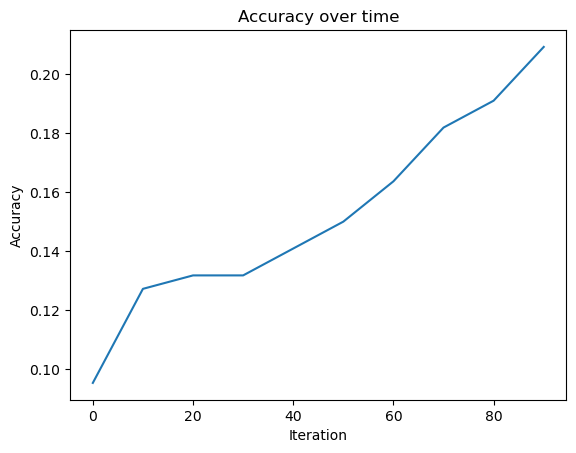

In [177]:
#Learning graph, accuracy over iterations
plt.title("Accuracy over time") 
plt.xlabel("Iteration") 
plt.ylabel("Accuracy") 
plt.plot(iteration,accuracy) 
plt.show()

In [119]:
#Use this code section for random images from booted dataset. For custom images, look down
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    
    print(prediction)
    
    print("Prediction: ", label_dict[str(int(prediction))])
    print("Label: ", label_dict[str(int(label))])
    
    print("Prediction numerical label: ", prediction)
    print("Numerical label: ", label)
    
    current_image = current_image.reshape((28, 224)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    
    if int(prediction) != label:
        print("Wrong prediction!")
        return False
    else:
        print("Correct prediction!")
        return True
   


[9]
Prediction:  constan
Label:  constan
Prediction numerical label:  [9]
Numerical label:  9


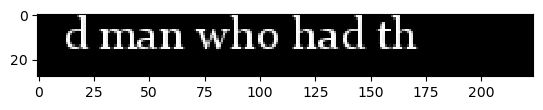

Correct prediction!


True

In [120]:
test_prediction(18, W1, b1, W2, b2)

[0]
Prediction:  arial
Label:  arial
Prediction numerical label:  [0]
Numerical label:  0


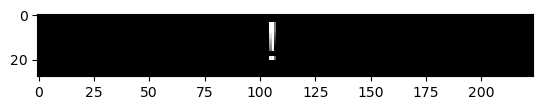

Correct prediction!
[7]
Prediction:  comic
Label:  comic
Prediction numerical label:  [7]
Numerical label:  7


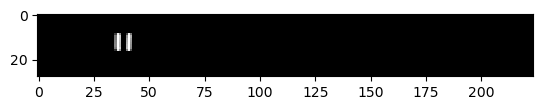

Correct prediction!
[6]
Prediction:  mvboli
Label:  mvboli
Prediction numerical label:  [6]
Numerical label:  6


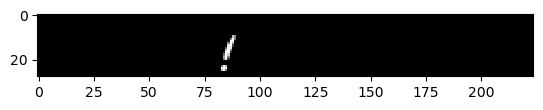

Correct prediction!
[9]
Prediction:  constan
Label:  constan
Prediction numerical label:  [9]
Numerical label:  9


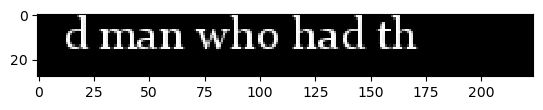

Correct prediction!
[4]
Prediction:  ebrima
Label:  ebrima
Prediction numerical label:  [4]
Numerical label:  4


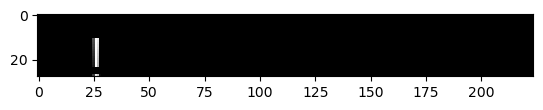

Correct prediction!
[7]
Prediction:  comic
Label:  comic
Prediction numerical label:  [7]
Numerical label:  7


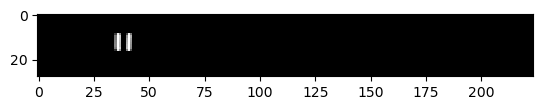

Correct prediction!
[7]
Prediction:  comic
Label:  comic
Prediction numerical label:  [7]
Numerical label:  7


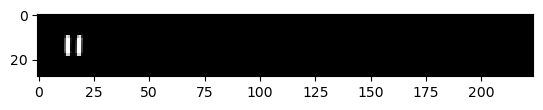

Correct prediction!
[6]
Prediction:  mvboli
Label:  mvboli
Prediction numerical label:  [6]
Numerical label:  6


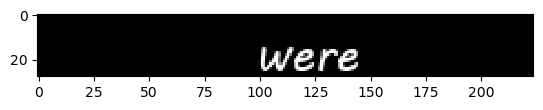

Correct prediction!
[4]
Prediction:  ebrima
Label:  ebrima
Prediction numerical label:  [4]
Numerical label:  4


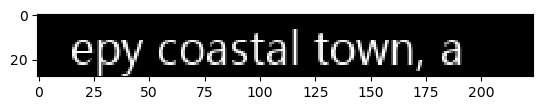

Correct prediction!
[7]
Prediction:  comic
Label:  comic
Prediction numerical label:  [7]
Numerical label:  7


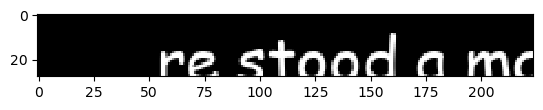

Correct prediction!
Accuracy: 1.0


In [124]:
#Getting accuracy of random parts of booted dataset
num_of_iterations = 0
correct_count = 0

for iter in range(0, 10):
    rand_sample = random.randint(0, 19)
    num_of_iterations += 1
    if test_prediction(rand_sample, W1, b1, W2, b2) == True:
        correct_count += 1        
accuracy = correct_count / num_of_iterations
print("Accuracy: " + str(accuracy))


In [68]:
#Use this code section for custom booted images
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(my_image, W1, b1, W2, b2):
    current_image = my_image
    prediction = make_predictions(my_image, W1, b1, W2, b2)
    
    print("Prediction: ", label_dict[str(int(prediction))])
    print("Prediction numerical label: ", prediction)
    
    current_image = current_image.reshape((28, 224)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  calibrii
Prediction numerical label:  [1]


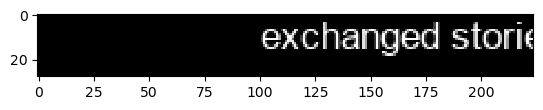

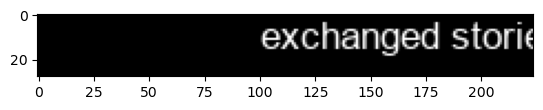

In [72]:
#Enter the name of your image, you want to check font of. 

#Your image has to be 224x28pixels!
image_name = "/home/zule/anaconda3/envs/AlpNum/Font-Recognizer/Renders/arial.ttf29.png"
image = cv.imread(image_name)
cv_image = cv.cvtColor(np.array(image), cv.COLOR_RGB2BGR)
cv_image_gs = cv.cvtColor(cv_image, cv.COLOR_BGR2GRAY)

#If you have white background use this line of code
#cv_image_gs = ~cv_image_gs

image_array = np.asarray(cv_image_gs)
oneDimensionArray = image_array.flatten()
oneDimensionArray = oneDimensionArray / 255

oneDimensionArray = np.reshape(oneDimensionArray, (-1, 1))

test_prediction(oneDimensionArray, W1, b1, W2, b2)
plt.imshow(cv_image_gs, cmap='gray')





In [ ]:
# Save params from a file
import pickle

# After training the model, save the parameters
def save_params(W1, b1, W2, b2):
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    with open(my_dir_path + "/params.pkl", "wb") as f:
        pickle.dump(params, f)

save_params(W1, b1, W2, b2)

print(W1, b1, W2, b2)

In [ ]:
# Load parameters from a file
def load_params():
    with open(my_dir_path + "/params.pkl", "rb") as f:
        params = pickle.load(f)
        
    return params["W1"], params["b1"], params["W2"], params["b2"]

# Use it like this
W1, b1, W2, b2 = load_params()